In [2]:
import numpy as np
import pandas as pd
import math
import os
import shutil
import scipy.io as sio
import matplotlib.pyplot as plt
import os
from os.path import join, basename, dirname
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from glob import glob

In [3]:
matrixPathList = glob('/data/bswift-1/Pessoa_Lab/eCON/dataset/results_ShockUncensored/CON???/controllable/splitted_regs/shock_analysis/noProx/buttonPress/subj???.xmat.1D')

In [4]:
len(matrixPathList)

61

## Pairwise correlation values for regs of interest

In [6]:
corrmat_list = []; VIF = pd.DataFrame([])
i = 0
for matrix in matrixPathList:
    subj=basename(dirname(dirname(dirname(dirname(dirname(dirname(matrix)))))))
    if subj not in ['CON001','CON062','CON060','CON071','CON105']:
        raw_cols = open(matrix,'r').readlines()[3].split('"')[1].split(';')
        cols = [y for y in [x for x in raw_cols if "Run" not in x] if "Motion" not in y]
        design = np.loadtxt(matrix)
        tmp_df = pd.DataFrame(design,columns=raw_cols)
        df_corr = tmp_df[cols].corr()
        corrmat_list.append(df_corr.corr().values)
        df_for_VIF = tmp_df[cols]
        df_for_VIF = sm.add_constant(df_for_VIF)
        VIF_df = pd.DataFrame()
        VIF_df['Feature'] = df_for_VIF.columns
        VIF_df['Subject'] = subj
        VIF_df['VIF'] = [variance_inflation_factor(df_for_VIF.values, i) for i in range(df_for_VIF.shape[1])]
        VIF = pd.concat([VIF,VIF_df],axis=0)

corrmat = np.stack(corrmat_list,axis=2)
mean_corrmat = np.mean(corrmat,axis=2)
df_mean_corrmat = pd.DataFrame(mean_corrmat, index=cols, columns=cols)

In [7]:
subj

'CON117'

In [8]:
matrix

'/data/bswift-1/Pessoa_Lab/eCON/dataset/results_ShockUncensored/CON117/controllable/splitted_regs/shock_analysis/noProx/buttonPress/subj117.xmat.1D'

In [9]:
df_mean_corrmat.columns

Index([' signNearest#0 ', ' signNear#0 ', ' signFar#0 ', ' magNearest#0 ',
       ' magNear#0 ', ' magFar#0 ', ' signXmagNearest#0 ', ' signXmagNear#0 ',
       ' signXmagFar#0 ', ' v_motion#0 ', ' onset_block#0 ',
       ' offset_block#0 ', ' onset_shock1#0 ', ' onset_shock2#0 ',
       ' onset_shock3#0 ', ' onset_shock4#0 ', ' onset_shock5#0 ',
       ' onset_shock6#0 ', ' button_press1#0 ', ' button_press2#0 ',
       ' button_press3#0 ', ' button_press4#0 ', ' button_press5#0 ',
       ' button_press6#0 '],
      dtype='object')

Text(0.5, 1, 'Mean correlation')

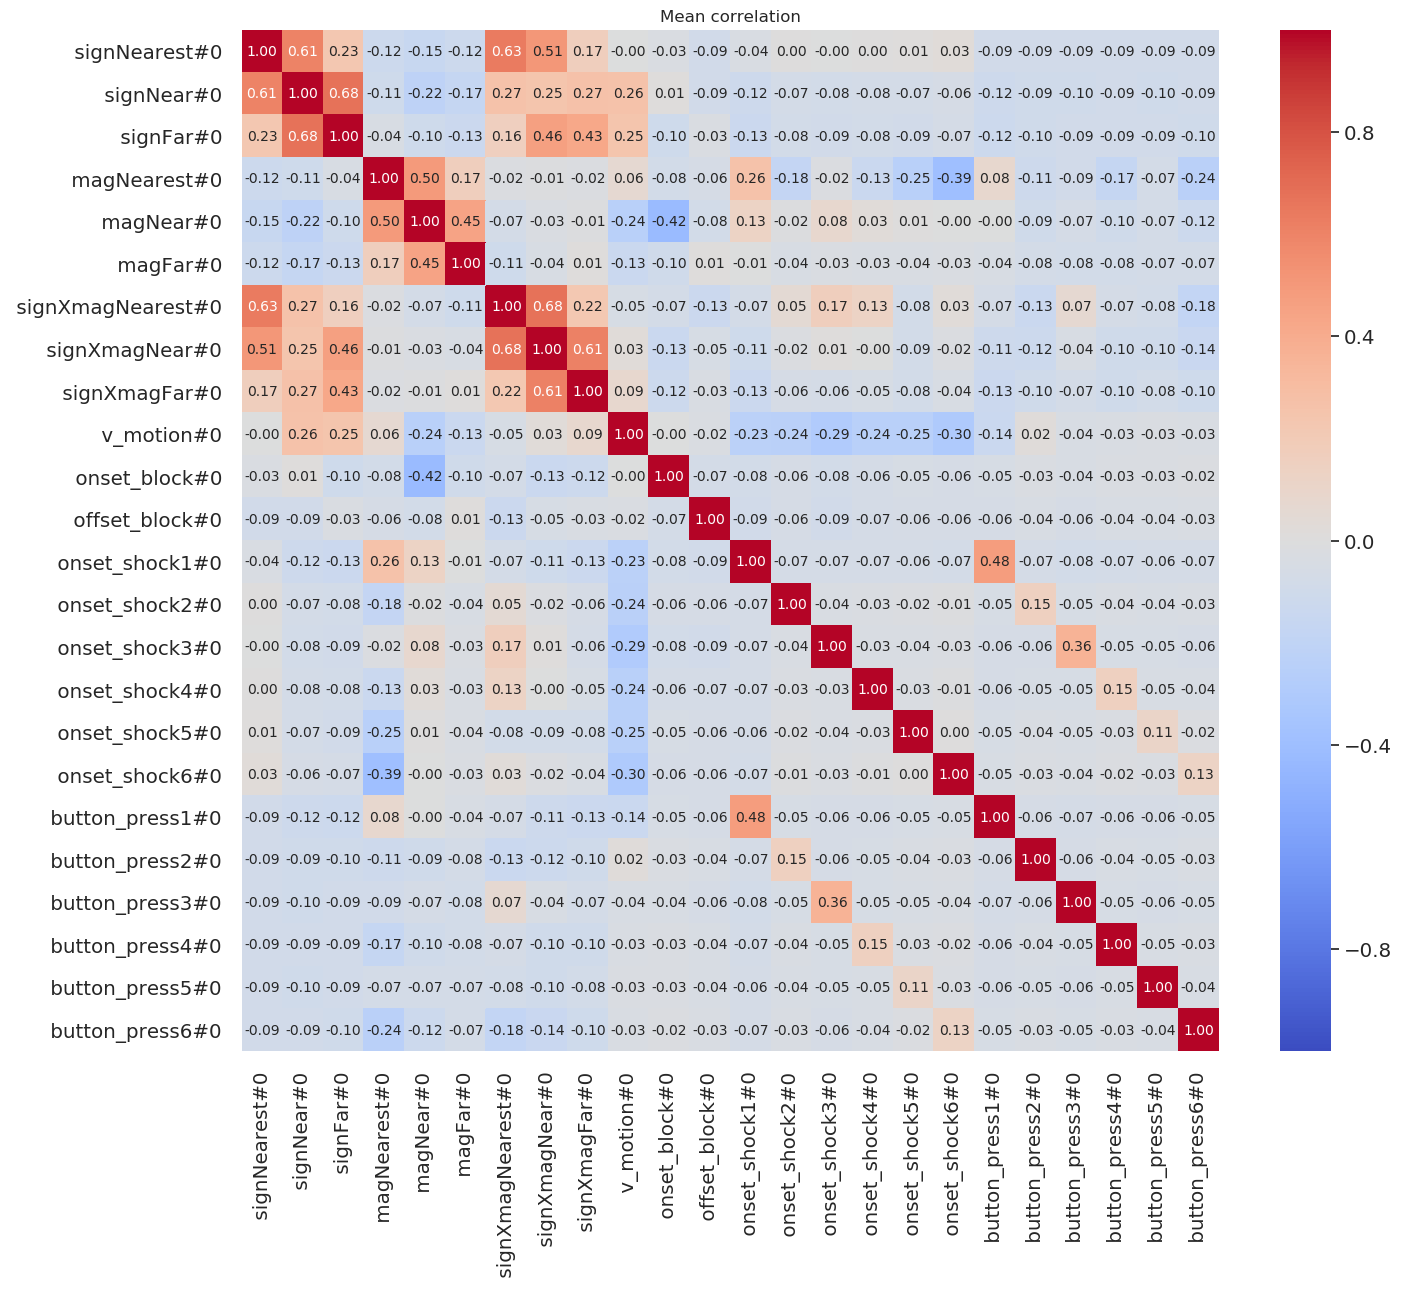

In [14]:
sns.set(font_scale=1.3)
fig = plt.figure(dpi = 100)
fig.set_size_inches(15,13,forward=True)
ax = sns.heatmap(df_mean_corrmat, vmin=-1
                 ,vmax=1, center=0, cmap='coolwarm',annot=True, fmt='.2f', annot_kws={"size": 10})
plt.tight_layout()
plt.title("Mean correlation", fontsize = 12)
#fig.savefig("figures/model3_corr.png")

## VIF for regs of interest

In [16]:
new_VIF = VIF.copy().drop(index=0)

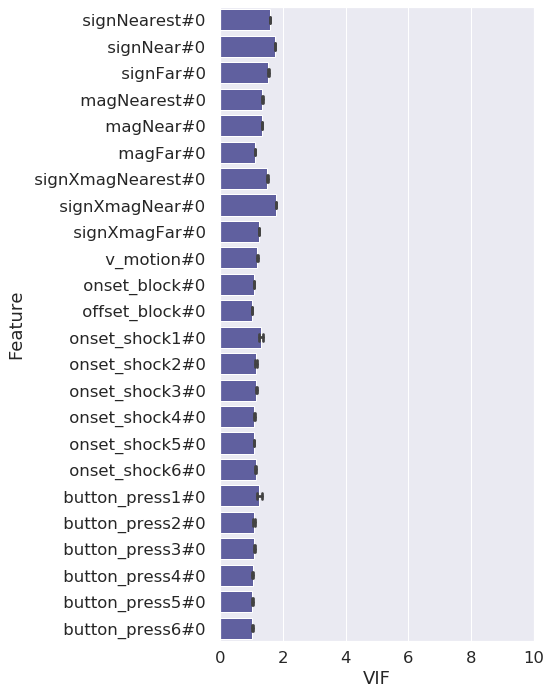

In [17]:
plt.figure(figsize=(8,10))
sns.set(font_scale=1.5)
sns.barplot(y='Feature',x='VIF',data=new_VIF,saturation=0.25,capsize=0.25,color='blue')
plt.xlim(0, 10)
plt.tight_layout()
#plt.savefig('figures/model3_VIFs.png')

In [18]:
new_VIF['VIF'].max()

2.9082989277999878

In [2]:
regpath= '../../dataset/preproc2/CON{subj}/regs_fancy'
main_path = "../../dataset/results_ShockUncensored"
yoked = pd.read_excel('../../onsetdir/CON_yoked_table.xlsx')
yoked = yoked.query("use == 1")
cormat_uncensored = np.zeros((12,12))
cormat_censored = cormat_uncensored

VIFs_uncensored = pd.DataFrame(columns=['Subject','Feature','VIF'])
VIFs_censored = pd.DataFrame(columns=['Subject','Feature','VIF'])

for _, row in yoked.iterrows():
    for j,k in zip(['controllable','uncontrollable'],['control','uncontrol']):
        sid = row[k].replace('CON','')
        cols = open(main_path+"/"+row[k]+"/"+j+"/subj{}".format(sid)+".xmat.1D",'r').readlines()[3].split("=")[1].split('"')[1].split(';')
        colnames = [y for y in [x for x in cols if "Run" not in x] if "Motion" not in y]
        data_uncensored = np.loadtxt(main_path+"/"+row[k]+"/"+j+"/subj{}".format(sid)+".xmat.1D")
        
        #### For censored version, uncomment the following block of code######
        censor15 = np.loadtxt(join(regpath.format(subj=sid),'CON{subj}_censor15.txt'.format(subj=sid)))
        indx_1 = np.where(censor15==1)
        data_censored = np.squeeze(data_uncensored[indx_1,:])
        df_censored = pd.DataFrame(data_censored,columns=cols)
        df_censored = df_censored.corr()
        clean_df_censored= df_censored[colnames].loc[colnames]
        cormat_censored = np.dstack((cormat_censored,clean_df_censored.values))
        ######################################################################
        df_uncensored = pd.DataFrame(data_uncensored,columns=cols)
        df_uncensored = df_uncensored.corr()
        clean_df_uncensored= df_uncensored[colnames].loc[colnames]
        cormat_uncensored = np.dstack((cormat_uncensored,clean_df_uncensored.values))
        
        
        ## VIFs ##
        VIF_df_uncensored = pd.DataFrame(data_uncensored,columns=cols)
        VIF_df_uncensored = sm.add_constant(VIF_df_uncensored[colnames])
        VIF_tmp_uncensored = pd.DataFrame()
        VIF_tmp_uncensored['Feature'] = VIF_df_uncensored.columns
        VIF_tmp_uncensored['Subject'] = 'CON{subj}'.format(subj=sid)
        VIF_tmp_uncensored['VIF'] = [variance_inflation_factor(VIF_df_uncensored.values, i) for i in range(VIF_df_uncensored.shape[1])]
        VIFs_uncensored = pd.concat([VIFs_uncensored,VIF_tmp_uncensored],axis=0)
        
        VIF_df_censored = pd.DataFrame(data_censored,columns=cols)
        VIF_df_censored = sm.add_constant(VIF_df_censored[colnames])
        VIF_tmp_censored = pd.DataFrame()
        VIF_tmp_censored['Feature'] = VIF_df_censored.columns
        VIF_tmp_censored['Subject'] = 'CON{subj}'.format(subj=sid)
        VIF_tmp_censored['VIF'] = [variance_inflation_factor(VIF_df_censored.values, i) for i in range(VIF_df_censored.shape[1])]
        VIFs_censored = pd.concat([VIFs_censored,VIF_tmp_censored],axis=0)


C:\Users\climbach\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1543: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [3]:
colnames2= ['Prox','Dir','Speed','ProxXDir','ProxXSpeed','DirXSpeed','ProxXDirXSpeed','Visual Motion','Block','Block Onset','Block Offset','Shock Onset']
mean_mat_uncensored = np.mean(cormat_uncensored,axis=2)
mean_df_uncensored = pd.DataFrame(mean_mat_uncensored,index=colnames2,columns=colnames2)

mean_mat_censored = np.mean(cormat_censored,axis=2)
mean_df_censored = pd.DataFrame(mean_mat_censored,index=colnames2,columns=colnames2)

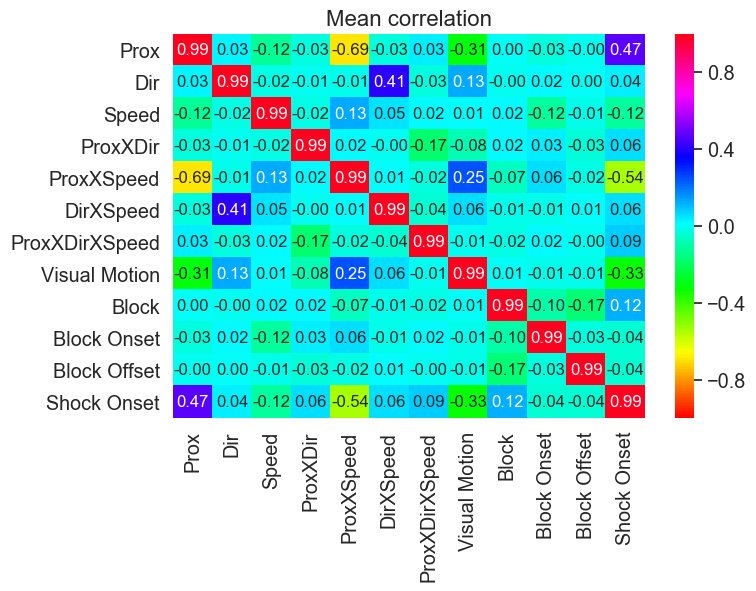

In [4]:
sns.set(font_scale=1.3)
fig = plt.figure(figsize=(8,6), dpi = 100)
fig.set_size_inches(8,6,forward=True)
ax = sns.heatmap(mean_df_uncensored, vmin=-1,vmax=1, center=0, cmap='hsv',annot=True, fmt='.2f', annot_kws={"size": 12})
plt.tight_layout()
plt.title("Mean correlation", fontsize = 16)
fig.savefig("figures/mean_corr_mat_uncensored.png")

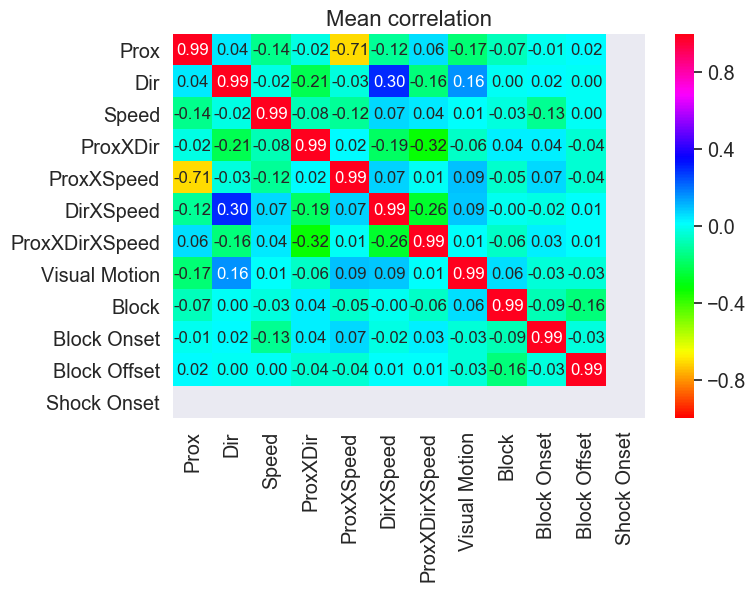

In [5]:
sns.set(font_scale=1.3)
fig = plt.figure(figsize=(8,6), dpi = 100)
fig.set_size_inches(8,6,forward=True)
ax = sns.heatmap(mean_df_censored, vmin=-1,vmax=1, center=0, cmap='hsv',annot=True, fmt='.2f', annot_kws={"size": 12})
plt.tight_layout()
plt.title("Mean correlation", fontsize = 16)
fig.savefig("figures/mean_corr_mat_censored.png")

In [7]:
dmap = {key: string for key, string in zip(colnames,colnames2)}

VIFs_uncensored['Regressor'] = VIFs_uncensored['Feature'].map(dmap)
VIFs_censored['Regressor'] = VIFs_censored['Feature'].map(dmap)

C:\Users\climbach\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


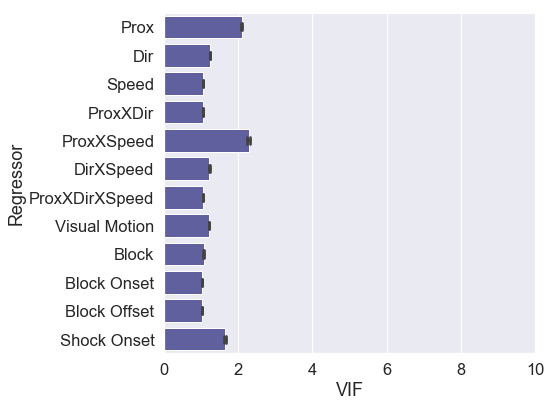

In [8]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.5)
sns.barplot(y='Regressor',x='VIF',data=VIFs_uncensored.drop(index=0),saturation=0.25,capsize=0.25,color='blue')
plt.xlim(0, 10)
plt.tight_layout()
plt.savefig('figures/VIFs_uncensored.png')

In [22]:
VIFs_uncensored.groupby('Regressor')['VIF'].mean()

Regressor
Block             1.065673
Block Offset      1.037403
Block Onset       1.035238
Dir               1.236907
DirXSpeed         1.226681
Prox              2.095816
ProxXDir          1.054497
ProxXDirXSpeed    1.050810
ProxXSpeed        2.284214
Shock Onset       1.643482
Speed             1.050490
Visual Motion     1.206415
Name: VIF, dtype: float64

C:\Users\climbach\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


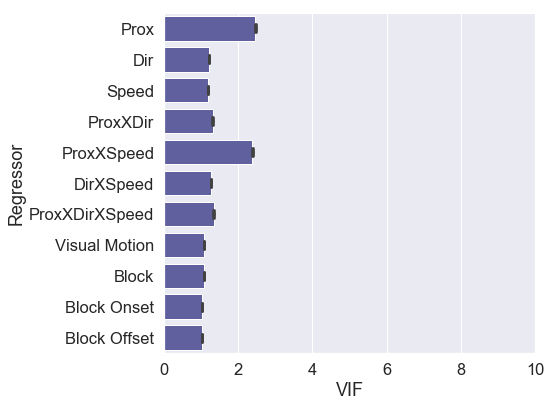

In [17]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.5)
sns.barplot(y='Regressor',x='VIF',data=VIFs_censored.drop(index=[0,12]),saturation=0.25,capsize=0.25,color='blue')
plt.xlim(0, 10)
plt.tight_layout()
plt.savefig('figures/VIFs_censored.png')

In [26]:
VIFs_censored.groupby('Regressor')['VIF'].mean()

Regressor
Block             1.078053
Block Offset      1.035123
Block Onset       1.036868
Dir               1.207944
DirXSpeed         1.263768
Prox              2.459506
ProxXDir          1.308796
ProxXDirXSpeed    1.336455
ProxXSpeed        2.375554
Shock Onset       1.007095
Speed             1.185621
Visual Motion     1.073414
Name: VIF, dtype: float64